In [1]:
# Importing all the parts we need
from typing import List, Optional

from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

import warnings

warnings.filterwarnings("ignore")

import math

pi = math.pi

# Preparing registers
quantum_register = QuantumRegister(16)
classical_register = ClassicalRegister(16)

initial_layout = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11 ,12, 13, 14, 15]

# The "even"" qubits will be used for the 54 qubit GHZ-state
ghz_qubits = [1, 7, 12, 14, 8, 3]

# The "odd" qubits will be used as the stabilizers
stabilizer_qubits = [4, 10, 13, 11, 5, 2]

# We do not take qubits 0, 6, 15, 9 into consideration

In [2]:
# Using Fake Provider
from qiskit.providers.fake_provider import FakeGuadalupe
from qiskit import transpile

# get a fake backend
backend = FakeGuadalupe()
number_of_shots: int = 1024

In [3]:
coupling_map = backend.configuration().coupling_map
edges = coupling_map
len(edges)

32

In [4]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw, graphviz_draw
from rustworkx.visit import BFSVisitor

G = rx.PyGraph()
indices = G.add_nodes_from(range(16))
for edge in edges:
    G.add_edge(edge[0], edge[1], None)
len(G.edges())

32

In [5]:
class TreeEdgesRecorder(BFSVisitor):

    def __init__(self):
        self.edges = []

    def tree_edge(self, edge):
        self.edges.append(edge)

def generate_ghz127(source_vertex, graph):
    qc = QuantumCircuit(quantum_register, classical_register)
    
    qr = quantum_register
    
    ####### your code goes here #######    
    ################## With layout ################
    
    vis = TreeEdgesRecorder()
    rx.bfs_search(graph, [source_vertex], vis)
    
    qc.h(qr[source_vertex])
    
    for edge in vis.edges:
        u, v, _ = edge
        qc.cx(qr[u], qr[v])
    
    ################################################
    
    return qc, vis.edges

ghz_circuit, edges = generate_ghz127(1, G)
print(ghz_circuit.depth())

8


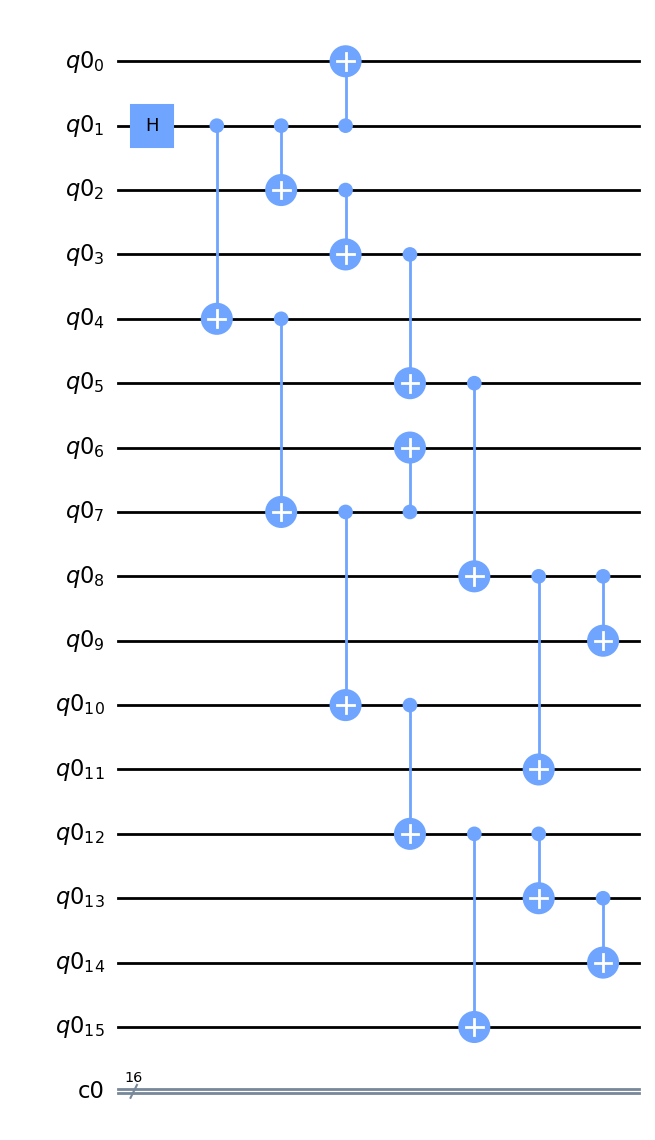

In [6]:
ghz_circuit.draw('mpl')

In [7]:
def deentangle_qubits(edges):
    qc = QuantumCircuit(quantum_register, classical_register)
    
    ####### your code goes here #######
    target_qubits = [i[1] for i in edges]
    
    qubits = stabilizer_qubits + [0,6,15,9]
    for qubit in qubits:
        index = target_qubits.index(qubit)
        u, v, _ = edges[index]
        qc.cx(quantum_register[u], quantum_register[v])
    
    return qc


unentangle_circuit = deentangle_qubits(edges)
print(unentangle_circuit.depth())

complete_circuit = ghz_circuit.compose(unentangle_circuit)

3


In [8]:
# Measuring stabilizers this can also be used in post processing to see what went wrong.

def measure_stabilizers():
    qc = QuantumCircuit(quantum_register, classical_register)
    qc.measure(stabilizer_qubits, stabilizer_qubits)
    return qc


stabilizer_circuit = measure_stabilizers()

In [9]:
# Measuring the GHZ qubits

def measure_ghz():
    qc = QuantumCircuit(quantum_register, classical_register)
    qc.measure(ghz_qubits, ghz_qubits)
    return qc


measure_circuit = measure_ghz()

In [10]:
# Everything together

simple_ghz = (
    ghz_circuit.compose(unentangle_circuit)
    .compose(stabilizer_circuit)
    .compose(measure_circuit)
)

In [11]:
# First we transpile the GHZ-state for the actual device
qc_transpiled = transpile(simple_ghz, backend, optimization_level=3, seed_transpiler = 3, initial_layout=initial_layout)
qc_transpiled.depth()

11

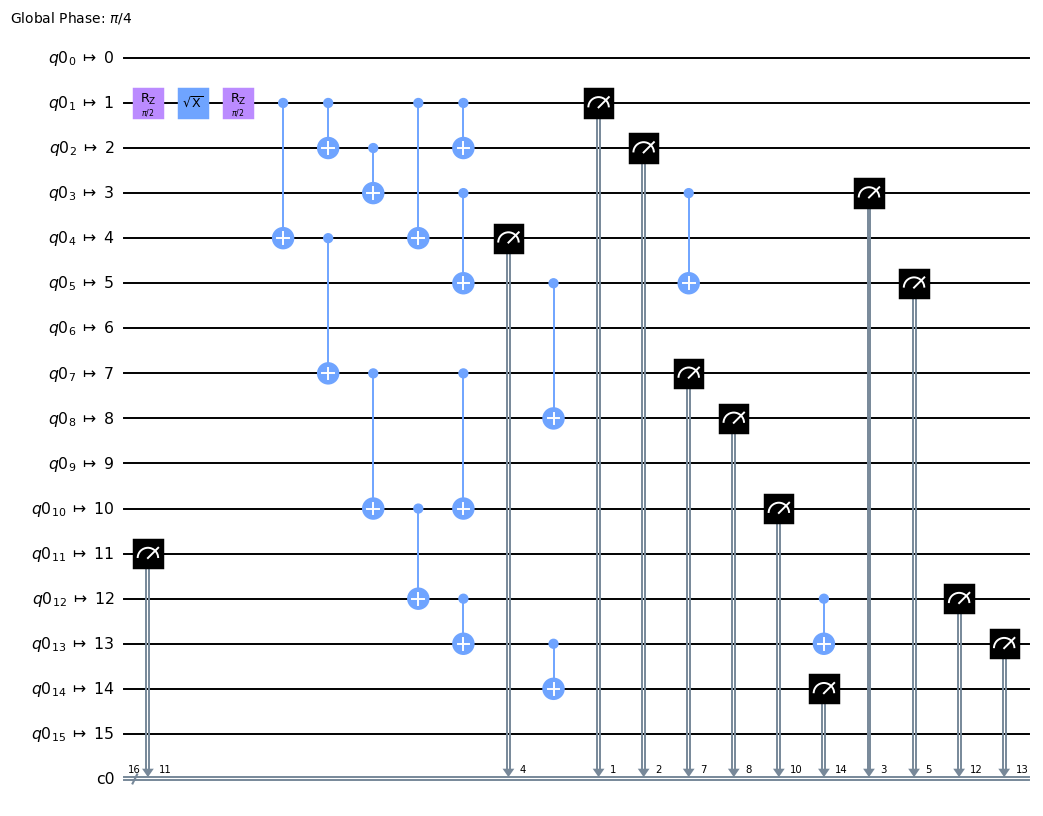

In [12]:
qc_transpiled.draw('mpl', scale=0.7)

In [13]:
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

sim = AerSimulator()
job = sim.run(qc_transpiled, shots=number_of_shots, memory=True)
result = job.result()
ideal_counts = result.get_counts()
data = result.get_memory()
ideal_counts

{'0000000000000000': 531, '0101000110001010': 493}

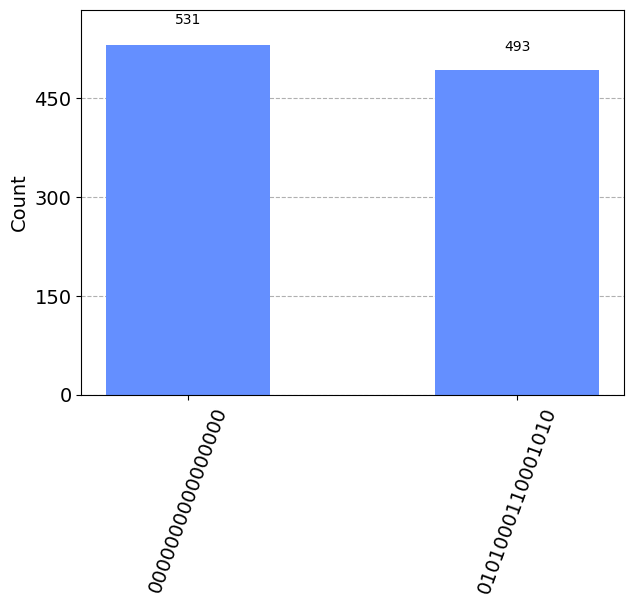

In [14]:
plot_histogram(ideal_counts)

In [15]:
bin_out = list(ideal_counts.keys())[1][::-1] 
indices = [i for i, x in enumerate(bin_out) if x == "0"]
indices

[0, 2, 4, 5, 6, 9, 10, 11, 13, 15]

In [16]:
job = backend.run(qc_transpiled, shots=number_of_shots, memory=True)
result = job.result()
noisy_counts = result.get_counts()

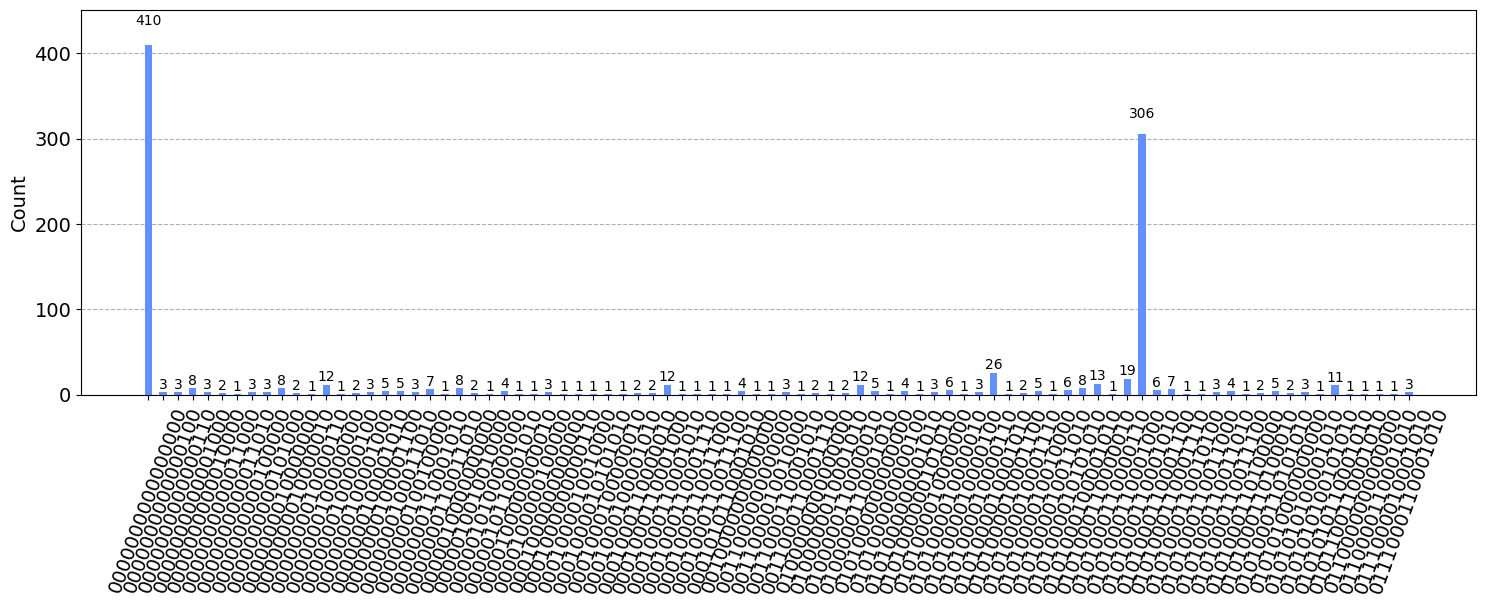

In [17]:
plot_histogram(noisy_counts, figsize=(18, 5))

In [18]:
# sort by value
sorted_noisy_counts = {k: v for k, v in sorted(noisy_counts.items(), key=lambda item: item[1], reverse=True)}

In [19]:
binary_keys = list(sorted_noisy_counts.keys())[:2]
binary_keys

['0000000000000000', '0101000110001010']

In [20]:
bin_out == binary_keys[1][::-1]

True

In [21]:
# Getting the data of the job for testing
noisy_data = job.result().get_memory()

In [22]:
import numpy as np

# A function to test the quality of a GHZ-state. The lower the better
def test_ghz(data):
    ghz_qubits = [1, 7, 12, 14, 8, 3]
    ####### your code goes here #######
    
    # change data endianess and extract necessary bits
    rev_data = [ expt[::-1] for expt in data]
    req_data = [ ''.join([expt[i] for i in ghz_qubits]) for expt in data]
    
    # Reference strings representing the ideal GHZ state
    num_qubits = len(ghz_qubits)
    shots = len(rev_data)
    
    num_all_ones = 0
    hdists = []
    
    for expt in req_data:
        
        # hamming distance
        num_ones = sum([ int(bit) for bit in expt])
        
        if num_ones >= num_qubits//2:
            # Assume that the state is all ones
            dist = num_qubits - num_ones
            num_all_ones += 1
        else:
            # Assume that the state is all zeros
            dist = num_ones
            
        hdists.append(dist)
    
    prob_all_ones = num_all_ones / shots
    mean_hdist = np.mean(hdists)/num_qubits
    
    print(f"Prob all ones: {prob_all_ones:.10f}")
    print(f"Mean hdist: {mean_hdist:.10f}")
    
    return prob_all_ones + mean_hdist

In [23]:
test_ghz(data)

Prob all ones: 0.4814453125
Mean hdist: 0.0000000000


0.4814453125

In [24]:
test_ghz(noisy_data)

Prob all ones: 0.5068359375
Mean hdist: 0.0576171875


0.564453125

In [25]:
import mthree

mapping = mthree.utils.final_measurement_mapping(qc_transpiled)
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(mapping)

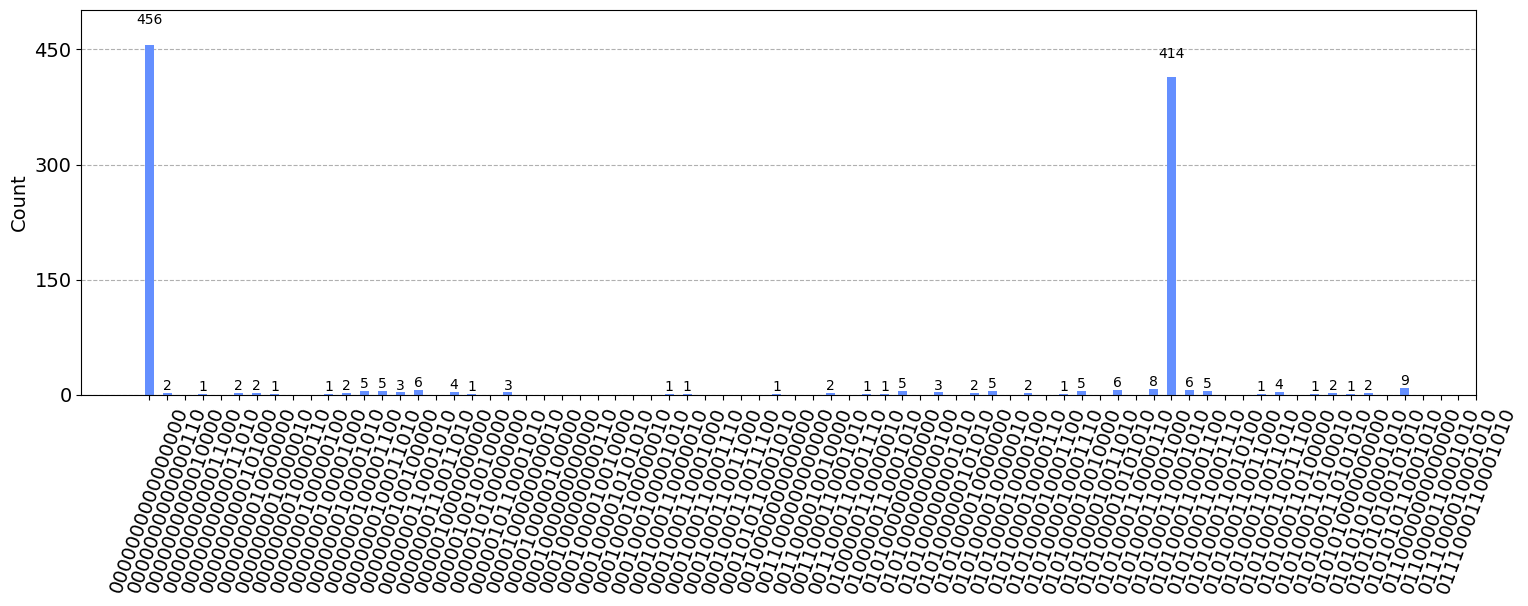

In [26]:
quasis = mit.apply_correction(noisy_counts, range(16))
mitigated_counts = quasis.nearest_probability_distribution()
mitigated_counts = {i: int(j*number_of_shots) for i, j in mitigated_counts.items()}
plot_histogram(mitigated_counts, figsize=(18, 5))

In [27]:
import itertools
mitigated_data = [ [i]*j for i, j in mitigated_counts.items() if j > 0]
mitigated_data = list(itertools.chain(*mitigated_data))
test_ghz(mitigated_data)

Prob all ones: 0.5066124110
Mean hdist: 0.0261105459


0.5327229569345542

In [28]:
# Simple idea for Example A find where the error happened and flip accordingly
def correct_ghz(edges):
    qc = QuantumCircuit(quantum_register, classical_register)
    
    target_qubits = [i[1] for i in edges]
    
    for qubit in stabilizer_qubits:
        index = target_qubits.index(qubit)
        u, v, _ = edges[index]
        
        qc.x(quantum_register[u]).c_if(classical_register[v], 1)
        
        # Dynamic circuit not yet supported on Guadalupe
        # with qc.if_test((classical_register[v], 1)):
        #     qc.x(quantum_register[u])

    qc.barrier()
    return qc


correcting_circuit = correct_ghz(edges)

In [29]:
# Everything together corrected

error_corrected_ghz = (
    ghz_circuit.compose(unentangle_circuit)
    .compose(stabilizer_circuit)
    .compose(correcting_circuit)
    .compose(measure_circuit)
)

In [30]:
# First we transpile the GHZ-state for the actual device
qc_corrected_transpiled = transpile(
    error_corrected_ghz, backend, seed_transpiler=3, initial_layout=initial_layout
)

qc_corrected_transpiled.depth()

14

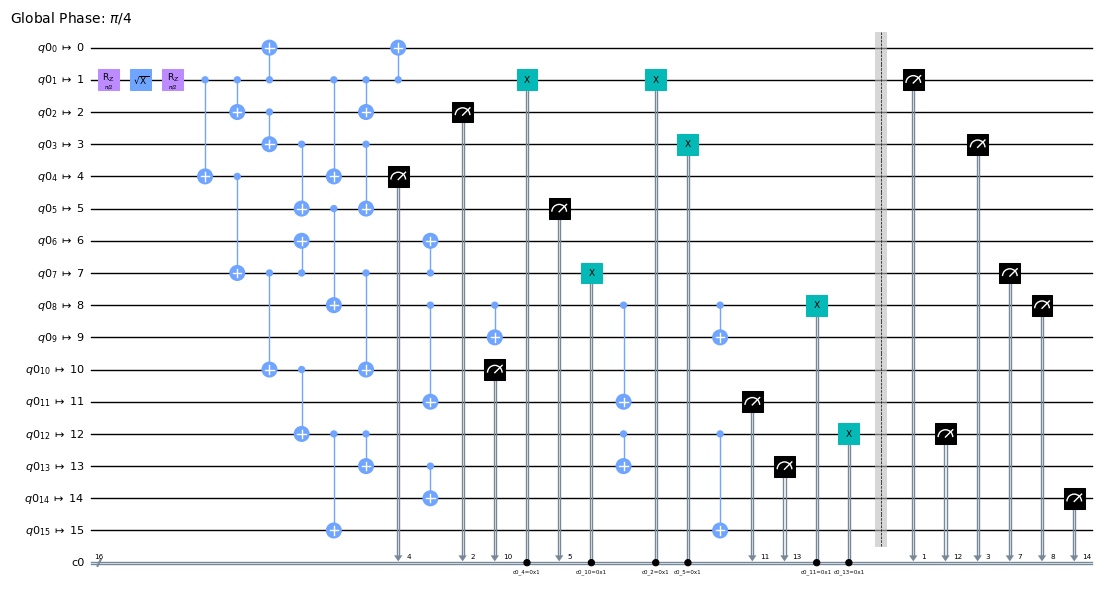

In [31]:
qc_corrected_transpiled.draw(fold=300, scale=0.5)

In [32]:
job = sim.run(qc_corrected_transpiled, shots=number_of_shots)
result = job.result()
ideal_counts = result.get_counts()
ideal_counts

{'0101000110001010': 498, '0000000000000000': 526}

In [33]:
job = backend.run(qc_corrected_transpiled, shots=number_of_shots, memory=True)
result = job.result()
noisy_corrected_counts = result.get_counts()

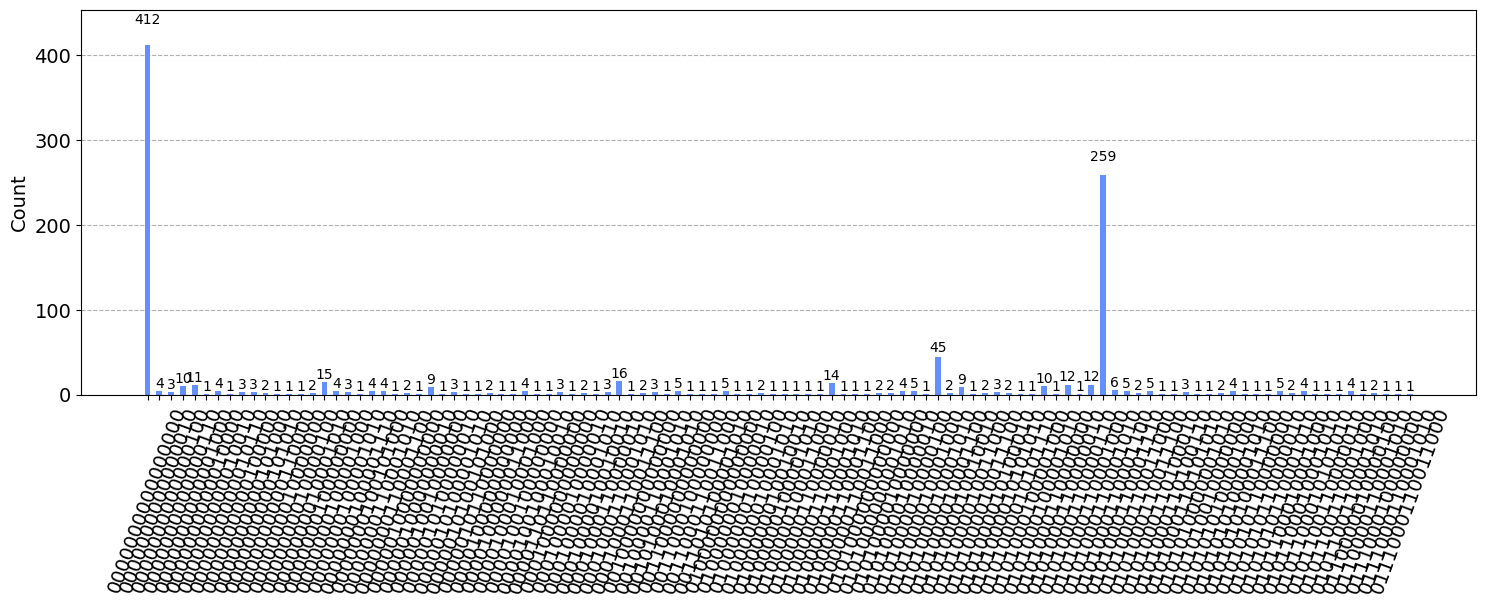

In [34]:
plot_histogram(noisy_corrected_counts, figsize=(18, 5))

In [35]:
# Getting the data of the job for testing
noisy_corrected_data = job.result().get_memory()
test_ghz(noisy_corrected_data)

Prob all ones: 0.4882812500
Mean hdist: 0.0725911458


0.5608723958333334

In [36]:
mapping = mthree.utils.final_measurement_mapping(qc_corrected_transpiled)
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(mapping)

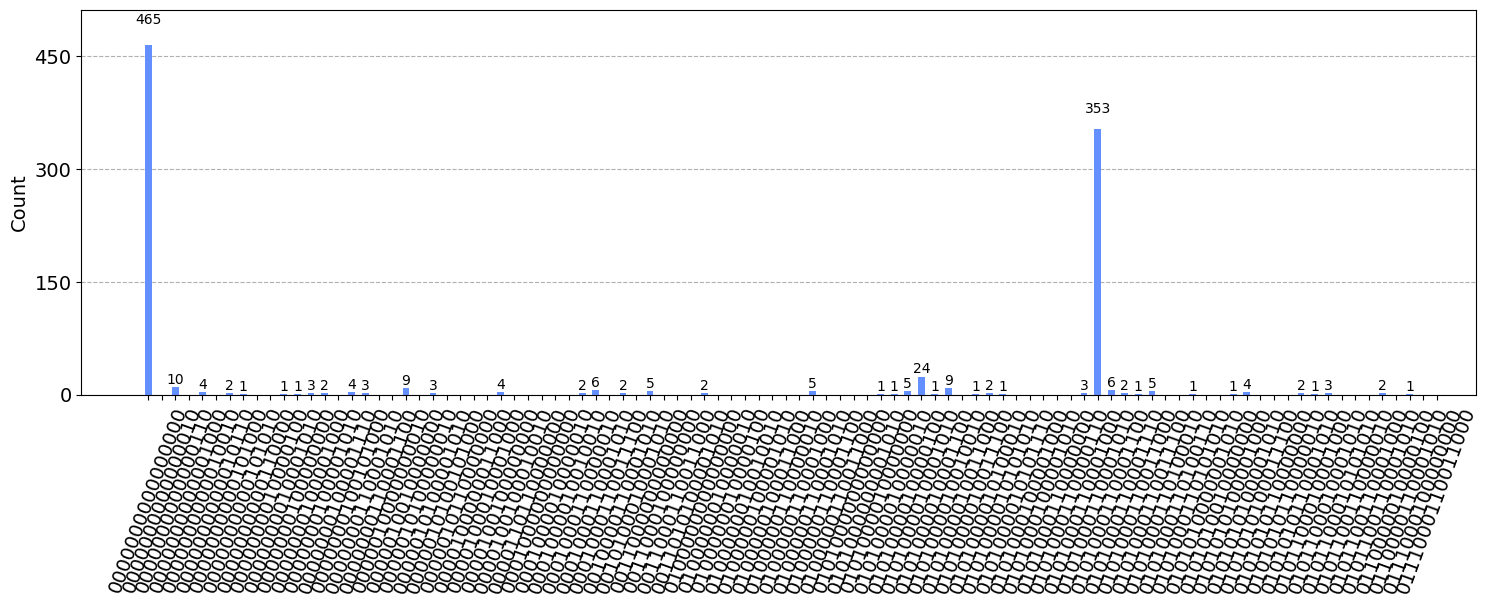

In [37]:
quasis = mit.apply_correction(noisy_corrected_counts, range(16))
mitigated_counts = quasis.nearest_probability_distribution()
mitigated_counts = {i: int(j*number_of_shots) for i, j in mitigated_counts.items()}
plot_histogram(mitigated_counts, figsize=(18, 5))

In [38]:
import itertools
mitigated_data = [ [i]*j for i, j in mitigated_counts.items() if j > 0]
mitigated_data = list(itertools.chain(*mitigated_data))
test_ghz(mitigated_data)

Prob all ones: 0.4709543568
Mean hdist: 0.0335408022


0.5044951590594744